In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse


## 矩阵检查，必须是数据型，必须是二维的
def check_array(array, dtype="numeric"):
    if issparse(array):
        raise TypeError('PCA does not support sparse input.')  # 不接受稀疏矩阵

    if array.ndim != 2:
        raise ValueError('Expected 2D array.')  # 只接受二维矩阵

    array = np.array(array, dtype=np.float64)
    return array



class GRA():
    def __init__(self, k=0, norm_method='norm', rho=0.5):
        self.k = k
        self.norm_method = norm_method
        self.rho = rho


    def fit(self, X, k=None):
        ''' 与单个参考序列比较 '''
        if not k==None: self.k = k
        X = check_array(X)
        Y = self.__normalization(X) #归一化
        self.r = self.__calculation_relevancy(Y)
        return self.r


    def fit_all(self, X):
        ''' 所有序列依次为参考序列，互相比较 '''
        X = check_array(X)
        self.data = np.zeros([X.shape[1], X.shape[1]])
        for k in range(X.shape[1]):
            self.k = k
            Y = self.__normalization(X) #归一化
            r = self.__calculation_relevancy(Y)
            self.data[:,k] = r
        return self.data


    def __normalization(self, X):
        if self.norm_method == 'mean':
            Y = self.__mean(X)
        elif self.norm_method == 'initial':
            Y = self.__initial(X)
        elif self.norm_method == 'norm':
            Y = self.__norm(X)
        elif self.norm_method == 'section':
            Y = self.__section(X)
        elif self.norm_method == 'max':
            Y = self.__max(X)
        elif self.norm_method == 'min':
            Y = self.__min(X)
        else:
            raise ValueError("Unrecognized norm_method='{0}'".format(self.norm_method))
        print(Y)
        return Y


    def __norm(self, X):
        Xsum = np.sum(X, axis=0)
        for i in range(X.shape[1]):
            X[:, i] = X[:, i]/Xsum[i]
        return X


    def __mean(self, X):
        ''' 平均值归一化 '''
        Xmean = np.mean(X, axis=0, keepdims=True) #每一列的平均
        for i in range(X.shape[1]):
            X[:, i] = X[:, i]/Xmean[0][i]
        return X


    def __initial(self, X):
        ''' 初值归一化 '''
        X0 = X[0,:]
        for i in range(X.shape[1]):
            X[:, i] = X[:, i]/X0[i]
        return X


    def __max(self, X):
        ''' 百分比归一化 '''
        Xmax = np.max(X, axis=0)
        for i in range(X.shape[1]):
            X[:, i] = X[:, i]/Xmax[i]
        return X


    def __min(self, X):
        ''' 倍数归一化 '''
        Xmin = np.min(X, axis=0)
        for i in range(X.shape[1]):
            X[:, i] = X[:, i]/(Xmin[i]+0.000001) #避免除数为零
        return X


    def __section(self, X):
        Xmax = np.max(X, axis=0)
        Xmin = np.min(X, axis=0)
        for i in range(X.shape[1]):
            X[:, i] = (X[:, i]-Xmin[i])/(Xmax[i]-Xmin[i])
        return X


    def __calculation_relevancy(self, X):
        ''' 计算关联度 '''
        # 计算参考序列与比较序列差值
        Delta = np.zeros((X.shape))
        for i in range(X.shape[1]):
            Delta[:, i] = np.fabs(X[:, i]-X[:, self.k])

        # 计算关联系数
        t = np.delete(Delta, self.k, axis=1)
        mmax=t.max().max()
        mmin=t.min().min()
        ksi=((mmin+self.rho*mmax)/(Delta+self.rho*mmax))

        # 计算关联度
        r = ksi.sum(axis=0) / ksi.shape[0]
        return r


    def sort_comparison(self):
        idxs = np.argsort(-self.r)
        data = []
        for idx in idxs:
            if idx == self.k: continue
            data.append(['第{}个特征'.format(idx), self.r[idx]])
        df = pd.DataFrame(
            data=np.array(data),
            columns=['特征','相关度'],
            index=[f"{i+1}" for i in range(len(data))],
        )
        print('\n与第{}个特征相关度的从大到小排序：'.format(self.k))
        print(df)
        return df


    def ShowGRAHeatMap(self):
        ''' 灰色关联结果矩阵可视化 '''
        df = pd.DataFrame(
            data=self.data,
            columns=[f"{i}" for i in range(self.data.shape[1])],
            index=[f"{i}" for i in range(self.data.shape[0])],
        )
        colormap = plt.cm.RdBu
        plt.figure()
        plt.title('Pearson Correlation of Features')
        sns.heatmap(df.astype(float), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
        plt.show()


In [2]:
import numpy as np

X = np.array([[1988,2061,2335,2750,3356,3806],[386,408,422,482,511,561], [839,846,960,1258,1577,1893], [763,808,953,1010,1268,1352],])


X=X.T # 每一行为一条记录，每一列为一个特征数据
print(X.shape)
print(X)

gra = GRA(k=0, norm_method='mean')
r = gra.fit(X)
print(r)
gra.sort_comparison()


(6, 4)
[[1988  386  839  763]
 [2061  408  846  808]
 [2335  422  960  953]
 [2750  482 1258 1010]
 [3356  511 1577 1268]
 [3806  561 1893 1352]]
[[0.73195876 0.83610108 0.68276143 0.7439064 ]
 [0.75883652 0.88375451 0.68845789 0.78778031]
 [0.85972018 0.91407942 0.78122881 0.92915177]
 [1.01251841 1.04404332 1.02373525 0.98472538]
 [1.23564065 1.10685921 1.28333107 1.23626909]
 [1.40132548 1.21516245 1.54048556 1.31816705]]
[1.00675156 0.50843241 0.62429583 0.75729962]

与第0个特征相关度的从大到小排序：
      特征                 相关度
1  第3个特征  0.7572996249999101
2  第2个特征   0.624295833506042
3  第1个特征  0.5084324125959353


,特征,相关度
1,第3个特征,0.7572996249999101
2,第2个特征,0.624295833506042
3,第1个特征,0.5084324125959353


[[2.         1.99951492 2.         2.         2.         2.        ]
 [0.38832998 0.39582828 0.3614561  0.35054545 0.3045292  0.29479769]
 [0.84406439 0.82076158 0.82226981 0.91490909 0.9398093  0.99474514]
 [0.76760563 0.78389522 0.81627409 0.73454545 0.7556615  0.71045717]]
[[2.         1.99951492 2.         2.         2.         2.        ]
 [0.38832998 0.39582828 0.3614561  0.35054545 0.3045292  0.29479769]
 [0.84406439 0.82076158 0.82226981 0.91490909 0.9398093  0.99474514]
 [0.76760563 0.78389522 0.81627409 0.73454545 0.7556615  0.71045717]]
[[2.         1.99951492 2.         2.         2.         2.        ]
 [0.38832998 0.39582828 0.3614561  0.35054545 0.3045292  0.29479769]
 [0.84406439 0.82076158 0.82226981 0.91490909 0.9398093  0.99474514]
 [0.76760563 0.78389522 0.81627409 0.73454545 0.7556615  0.71045717]]
[[2.         1.99951492 2.         2.         2.         2.        ]
 [0.38832998 0.39582828 0.3614561  0.35054545 0.3045292  0.29479769]
 [0.84406439 0.82076158 0.82226

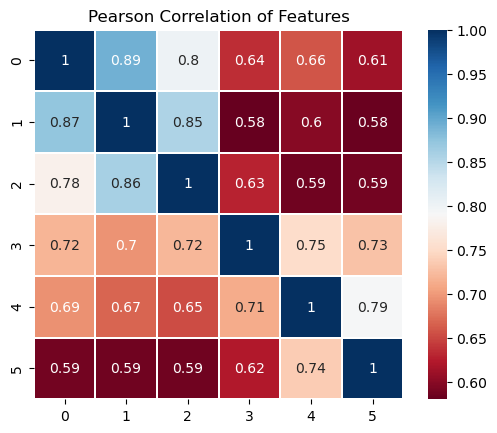

In [4]:
#from GRA import GRA
import numpy as np

X = np.array([[1988,2061,2335,2750,3356,3806],[386,408,422,482,511,561], [839,846,960,1258,1577,1893], [763,808,953,1010,1268,1352],])

gra = GRA(norm_method='mean')
data = gra.fit_all(X)
print(data)
gra.ShowGRAHeatMap()
